In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
train=pd.read_csv('../input/newtrain.csv')

In [3]:
train.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0  cyclin dependent kinase cdks regulate variety ...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrate acquire uniparenta...  
4  oncogenic mutation monomeric casita lineage ly...

In [4]:
test=pd.read_csv('../input/newtest.csv')

In [5]:
test.head()

ID     Gene Variation  Class  \
0   0    ACSL4     R570S      0   
1   1    NAGLU     P521L      0   
2   2      PAH     L333F      0   
3   3     ING1     A148D      0   
4   4  TMEM216      G77A      0   

                                                Text  
0  mutation result myeloproliferative phenotype i...  
1  abstract large tumor suppressor lats1 serine t...  
2  vascular endothelial growth factor receptor ve...  
3  inflammatory myofibroblastic tumor imt neoplas...  
4  abstract retinoblastoma pediatric retinal tumo...

In [6]:
import findspark
findspark.init()

In [7]:
from pyspark import SparkContext
from pyspark import SparkConf
conf = SparkConf()
conf.set('spark.executor.cores',4)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','20G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
sc=SparkContext(conf=conf)

In [20]:
def gen_n_gram(line,n):
    words=line.split(" ")
    grams=[]
    for i in range(len(words)-n):
        grams.append(" ".join(words[i:i+n]))
    return grams

# counting

In [6]:
#text=pd.concat([train.Text, test.Text]).values
text=train.Text.values
text.shape

(3321,)

In [10]:
sc.parallelize(range(100)).count()

100

In [11]:
textRDD = sc.parallelize(text,numSlices=1000)

In [12]:
textRDD.count()

3321

In [13]:
n=30
word_counts=textRDD.map(lambda u: gen_n_gram(u,n)).flatMap(lambda u:u).map(lambda u: (u,1)).reduceByKey(lambda u,v: u+v).sortBy(lambda u: -u[1]).cache()

In [14]:
word_counts.count()

6783084

In [23]:
word_counts.filter(lambda u: u[1]==2).take(4)

[('map reveal increase density rbm10 bind cluster close splice site intron flank skip cassette exon prominent enrichment splice site downstream intron rna splicing map rbm10 suggest rbm10 bind close splice',
  2),
 ('suggest proportion missense mutation likely pathogenic missense mutation occur bromodomain second bah domain figure bromodomain pbrm1 preferential bind different acetylated lysine configuration histone tail suggest contribute reading histone code11 likelihood',
  2),
 ('mtorc1 propose include mtor interact protein rag rheb deptor raptor pras40 fkbp38 figure hypothesize distinct mtor mutation cluster affect interaction regulation mtor specific mtor regulator contribute mtorc1 activation figure figure',
  2),
 ('pbaf baf chromatin remodel complex swi snf family essential mammalian transcription development complex share identical subunit pbaf facilitate transcriptional activation nuclear receptor vitro complex selectivity mediate transcription different interferon responsive

In [19]:
counts[counts.index>1].sum()

2498833

In [16]:
counts=pd.Series(word_counts.map(lambda u: u[1]).collect()).value_counts()

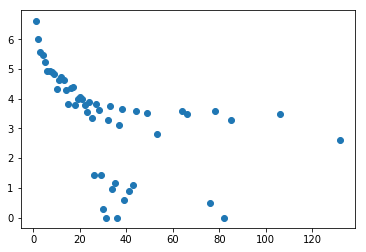

In [22]:
plt.scatter(counts.index,np.log10(counts.values))

In [22]:
len(text[0])

26770

In [24]:
word_counts.filter(lambda u: u[1]>1).saveAsPickleFile("/tmp/pwc30")

# map

In [8]:
word_counts=sc.pickleFile("/tmp/pwc30")

In [17]:
N=word_counts.count()
N

2498833

In [32]:
word_counts.take(2)

[('bar indicate percentage cell plasma membrane gfp stain high pip3 level low pten activity white color correspond percentage cell display nucleocytoplasmic gfp signal low pip3 level high pten activity 100',
  132),
 ('catalytic loop dimensional structure pten catalytic site region span wpd catalytic loop mark yellow red blue respectively image generate pymol http pymol org base pdb 1d5r amino acid sequence alignment',
  132)]

In [13]:
hash(word_counts.take(1)[0][0])

5919366658913736084

In [14]:
hash_words=word_counts.map(lambda u: hash(u[0])).collect()
hash_words[:2]

[5919366658913736084, 6238777337414194277]

In [17]:
bc_hash=sc.broadcast(set(hash_words))

In [26]:
train['newid']=train['ID'].apply(lambda u:'tr'+str(u))
test['newid']=test['ID'].apply(lambda u:'te'+str(u))
alltext=pd.concat([train,test],axis=0)[['newid','Text']]

In [29]:
alltext.head()

newid                                               Text
0   tr0  cyclin dependent kinase cdks regulate variety ...
1   tr1  abstract background non small cell lung cancer...
2   tr2  abstract background non small cell lung cancer...
3   tr3  recent evidence demonstrate acquire uniparenta...
4   tr4  oncogenic mutation monomeric casita lineage ly...

In [37]:
alltext.apply(lambda u: tuple(u),axis=1).tolist()

In [ ]:
textRDD=sc.parallelize(alltext.values, numSlices=1000)

In [ ]:
textRDD.map(lambda u: gen_n_gram(u,30) ).flatMap(lambda u: u).filter(lambda u: hash(u) in bc_hash)

# stop

In [39]:
sc.stop()